In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology, segmentation
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import canny, corner_harris, corner_peaks
from skimage.transform import hough_line, hough_line_peaks, hough_circle
from skimage.util import random_noise
import cv2  # Para algunas funciones complementarias

In [ ]:
## Ejercicio 1: Detección de Objetos por Color (Clasificación de Piezas)
def detectar_objetos_por_color(imagen):
    """
    Detecta y clasifica objetos por color
    """
    # Tu código aquí
    hsv = rgb2hsv(imagen)

    # Definir rangos HSV
    # Nota: cv2 usa [0-179] en H, pero skimage usa [0-1]
    # Por eso los rangos se normalizan a [0-1]

    # Rojo puede estar en dos rangos en HSV
    rojo_bajo = (hsv[:,:,0] < 0.05) | (hsv[:,:,0] > 0.95)
    rojo_mask = rojo_bajo & (hsv[:,:,1] > 0.4) & (hsv[:,:,2] > 0.3)

    azul_mask = (hsv[:,:,0] > 0.55) & (hsv[:,:,0] < 0.75) & (hsv[:,:,1] > 0.4)
    verde_mask = (hsv[:,:,0] > 0.25) & (hsv[:,:,0] < 0.45) & (hsv[:,:,1] > 0.4)

    masks = {"rojo": rojo_mask, "azul": azul_mask, "verde": verde_mask}

    resultados = {}

    # Procesar cada máscara
    for color, mask in masks.items():
        # Limpiar con morfología
        mask = morphology.remove_small_objects(mask, 50)
        mask = morphology.remove_small_holes(mask, 50)

        # Etiquetar objetos
        etiquetas = measure.label(mask)
        props = measure.regionprops(etiquetas)

        centroides = [prop.centroid for prop in props]

        resultados[color] = {
            "conteo": len(centroides),
            "centroides": centroides
        }

        # Dibujar centroides sobre la imagen
        for cy, cx in centroides:
            cv2.circle(imagen, (int(cx), int(cy)), 8, (255, 255, 255), -1)

    # Mostrar resultados
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(rojo_mask, cmap='gray')
    ax[0].set_title('Rojo')
    ax[1].imshow(azul_mask, cmap='gray')
    ax[1].set_title('Azul')
    ax[2].imshow(verde_mask, cmap='gray')
    ax[2].set_title('Verde')
    ax[3].imshow(imagen)
    ax[3].set_title('Centroides Detectados')

    print ('Objetos rojos detectados:')
    print (resultados['rojo'])
    print ('Objetos azules detectados:')
    print (resultados['azul'])
    print ('Objetos verdes detectados:')
    print (resultados['verde'])
    pass

In [51]:
## Ejercicio 2: Navegación por Líneas (Seguimiento de Trayectoria)
def seguir_linea(imagen):
    """
    Procesa imagen para seguimiento de línea
    Retorna: ángulo_giro, distancia_centro
    """
    # Preprocesamiento
    gray = rgb2gray(imagen)

    # Detección de bordes
    edges = canny(gray, sigma=2, low_threshold=0.1, high_threshold=0.2)

    # Tu código para Hough Transform aquí

    # 3. Transformada de Hough
    hspace, angles, dists = hough_line(edges)
    acc, angle_peaks, dist_peaks = hough_line_peaks(hspace, angles, dists)

    # Si detecta varias, tomamos la más fuerte
    if len(angle_peaks) > 0:
        angulo = angle_peaks[0]
        dist = dist_peaks[0]
    else:
        return None, None

    # 4. Convertir ángulo a grados más interpretables
    angulo_giro = np.rad2deg(angulo)

    # 5. Distancia al centro de la imagen
    centro_imagen = imagen.shape[1] / 2
    distancia_centro = dist - centro_imagen

    # --- Visualización ---
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(imagen)
    ax[0].set_title("Imagen Original")

    ax[1].imshow(edges, cmap="gray")
    ax[1].set_title("Bordes detectados")
    ax[1].axis("off")

    plt.show()

    print(f"Ángulo de la línea principal: {angulo_giro:.2f} grados")
    print(f"Distancia respecto al centro: {distancia_centro:.2f} píxeles")

    # Determinar dirección
    if distancia_centro > 0:
        direccion = "Girar a la derecha"
    elif distancia_centro < 0:
        direccion = "Girar a la izquierda"
    else:
        direccion = "Seguir recto"

    print("Instrucción:", direccion)

    return angulo_giro, distancia_centro

In [60]:
## Ejercicio 3: Detección y Medición de Objetos (Control de Calidad)
def control_calidad(imagen, tolerancia_area=0.1, factor_mm2=0.01):
    """
    Analiza piezas para control de calidad
    """
    # Segmentación
    gray = rgb2gray(imagen)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh

    # Análisis morfológico
    cleaned = morphology.remove_small_objects(binary, min_size=100)
    etiquetas = measure.label(cleaned)

    # Extraer propiedades
    props = measure.regionprops(etiquetas)

    resultados_medicion = []
    for i, region in enumerate(props, start=1):
        area_px = region.area
        area_mm2 = area_px * factor_mm2
        perimetro = region.perimeter
        minr, minc, maxr, maxc = region.bbox
        largo = maxr - minr
        ancho = maxc - minc
        aspect_ratio = largo / ancho if ancho > 0 else 0

        # Circularidad
        circularidad = (4 * np.pi * area_px) / (perimetro**2) if perimetro > 0 else 0

        # Agujeros (Euler number = objetos - agujeros)
        num_agujeros = 1 - region.euler_number

        # Clasificación simple: defectuosa si tiene agujeros o circularidad muy baja
        if num_agujeros > 0 or circularidad < 0.4:
            estado = "Defectuosa"
        else:
            estado = "Aprobada"

        resultados_medicion.append({
            "pieza": i,
            "area_px": area_px,
            "area_mm2": round(area_mm2, 2),
            "perimetro": round(perimetro, 2),
            "aspect_ratio": round(aspect_ratio, 2),
            "circularidad": round(circularidad, 2),
            "agujeros": num_agujeros,
            "estado": estado
        })
    plt.imshow(etiquetas, cmap='nipy_spectral')
    for resultado in resultados_medicion:
        print(resultado)

    # Tu código para mediciones aquí

    return resultados_medicion

In [61]:
## Ejercicio 4: Reconocimiento de Formas Geométricas
def clasificar_formas(imagen):
    """
    Clasifica objetos por su forma geométrica
    """
    # Detección de contornos
    gray = rgb2gray(imagen)
    edges = canny(gray, sigma=1)

    # Convertir a formato uint8 para OpenCV
    edges_cv = (edges * 255).astype(np.uint8)

    # Análisis de forma
    contours, _ = cv2.findContours(edges_cv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    formas_detectadas = []

    for contour in contours:
        # Tu código para clasificación aquí
        # Usa aproximación poligonal, análisis de curvatura, etc.
        # Aproximación poligonal
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx)

        # Calcular momentos para orientación y centroide
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Clasificación según vértices
        if num_vertices == 3:
            forma = "Triangulo"
        elif num_vertices == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            forma = "Cuadrado" if 0.9 < aspect_ratio < 1.1 else "Rectangulo"
        elif num_vertices > 6:
            forma = "Circulo"
        else:
            forma = "Poligono"

        # Orientación con PCA (eigenvectors de los puntos)
        coords = contour[:, 0, :]
        mean, eigvecs = cv2.PCACompute(coords.astype(np.float32), mean=np.array([]))
        angulo = np.degrees(np.arctan2(eigvecs[0,1], eigvecs[0,0]))

        formas_detectadas.append({
            "forma": forma,
            "centroide": (cx, cy),
            "angulo": round(angulo, 2),
            "agarre": [(cx-10, cy), (cx+10, cy)]  # puntos de agarre simples
        })

        # Dibujar resultados
        cv2.drawContours(imagen, [approx], -1, (0,255,0), 2)
        cv2.circle(imagen, (cx, cy), 5, (255,0,0), -1)
        cv2.putText(imagen, forma, (cx-30, cy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    # Mostrar
    plt.figure(figsize=(6,6))
    plt.imshow(imagen)
    plt.title("Formas detectadas")
    plt.axis("off")
    plt.show()

    return formas_detectadas

Objetos rojos detectados:
{'conteo': 1, 'centroides': [(np.float64(259.9490087221923), np.float64(250.0583979056214))]}
Objetos azules detectados:
{'conteo': 2, 'centroides': [(np.float64(288.2437190558434), np.float64(696.982130109384)), (np.float64(669.4485263213197), np.float64(234.61507040033624))]}
Objetos verdes detectados:
{'conteo': 1, 'centroides': [(np.float64(712.0169002232326), np.float64(725.4331763303375))]}


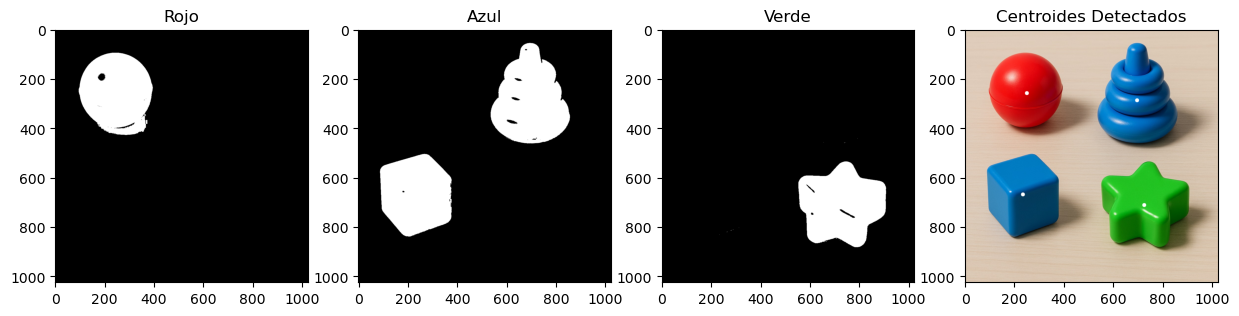

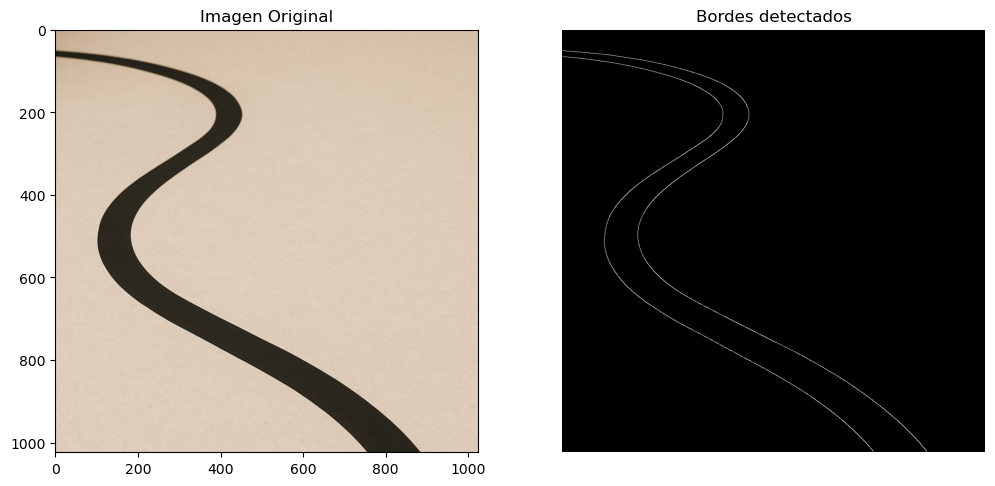

Ángulo de la línea principal: -63.00 grados
Distancia respecto al centro: -953.00 píxeles
Instrucción: Girar a la izquierda
{'pieza': 1, 'area_px': np.float64(664340.0), 'area_mm2': np.float64(6643.4), 'perimetro': np.float64(14115.31), 'aspect_ratio': 1.0, 'circularidad': np.float64(0.04), 'agujeros': np.int64(475), 'estado': 'Defectuosa'}
{'pieza': 2, 'area_px': np.float64(317.0), 'area_mm2': np.float64(3.17), 'perimetro': np.float64(148.29), 'aspect_ratio': 0.4, 'circularidad': np.float64(0.18), 'agujeros': np.int64(0), 'estado': 'Defectuosa'}
{'pieza': 3, 'area_px': np.float64(105.0), 'area_mm2': np.float64(1.05), 'perimetro': np.float64(93.46), 'aspect_ratio': 0.41, 'circularidad': np.float64(0.15), 'agujeros': np.int64(1), 'estado': 'Defectuosa'}
{'pieza': 4, 'area_px': np.float64(132.0), 'area_mm2': np.float64(1.32), 'perimetro': np.float64(106.59), 'aspect_ratio': 0.45, 'circularidad': np.float64(0.15), 'agujeros': np.int64(5), 'estado': 'Defectuosa'}
{'pieza': 5, 'area_px': np

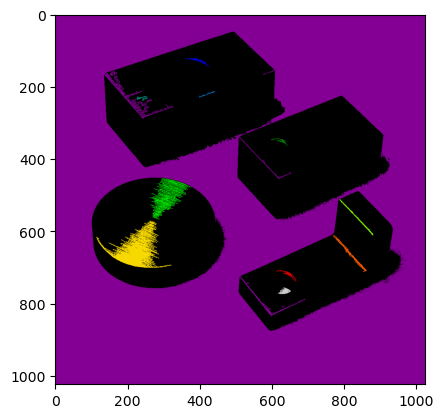

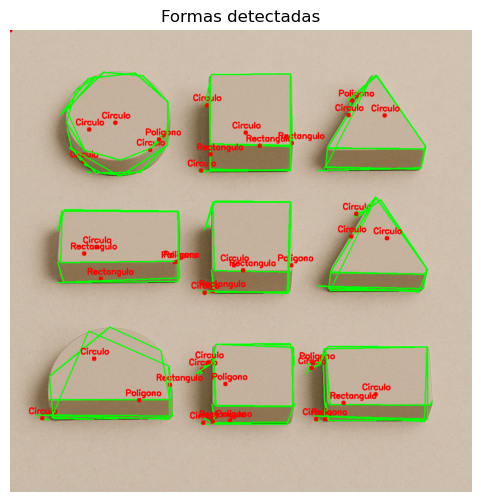

[{'forma': 'Circulo',
  'centroide': (428, 870),
  'angulo': np.float32(11.61),
  'agarre': [(418, 870), (438, 870)]},
 {'forma': 'Circulo',
  'centroide': (678, 862),
  'angulo': np.float32(5.49),
  'agarre': [(668, 862), (688, 862)]},
 {'forma': 'Poligono',
  'centroide': (0, 0),
  'angulo': np.float32(0.0),
  'agarre': [(-10, 0), (10, 0)]},
 {'forma': 'Poligono',
  'centroide': (0, 0),
  'angulo': np.float32(-0.38),
  'agarre': [(-10, 0), (10, 0)]},
 {'forma': 'Poligono',
  'centroide': (0, 0),
  'angulo': np.float32(-0.63),
  'agarre': [(-10, 0), (10, 0)]},
 {'forma': 'Circulo',
  'centroide': (71, 860),
  'angulo': np.float32(12.91),
  'agarre': [(61, 860), (81, 860)]},
 {'forma': 'Poligono',
  'centroide': (0, 0),
  'angulo': np.float32(90.0),
  'agarre': [(-10, 0), (10, 0)]},
 {'forma': 'Poligono',
  'centroide': (487, 866),
  'angulo': np.float32(-3.16),
  'agarre': [(477, 866), (497, 866)]},
 {'forma': 'Rectangulo',
  'centroide': (449, 867),
  'angulo': np.float32(3.97),
  'a

In [ ]:
image_1 = io.imread(r'C:\Users\Sergio\OneDrive\Escritorio\Robotica\Imagenes_Ej\WhatsApp Image 2025-09-18 at 6.30.00 PM.jpeg')
image_2 = io.imread(r'C:\Users\Sergio\OneDrive\Escritorio\Robotica\Imagenes_Ej\WhatsApp Image 2025-09-18 at 6.33.27 PM.jpeg')
image_3 = io.imread(r'C:\Users\Sergio\OneDrive\Escritorio\Robotica\Imagenes_Ej\WhatsApp Image 2025-09-18 at 6.35.25 PM.jpeg')
image_4 = io.imread(r'C:\Users\Sergio\OneDrive\Escritorio\Robotica\Imagenes_Ej\WhatsApp Image 2025-09-18 at 6.37.45 PM.jpeg')

detectar_objetos_por_color(image_1)

seguir_linea(image_2)

control_calidad(image_3)

clasificar_formas(image_4)
